# AstroHack - Tensorflow + Keras Example

This tutorial will demonstrate how to predict galaxy M/L ratios using a simple convolutional neural network with the Keras API of TensorFlow 2.0.

1. [Prepare data](#1.-Prepare-data)    
    1.1. [Load labels and metadata](#1.1.-Load-labels-and-metadata)    
    1.2. [Load images into np.arrays](#1.2.-Load-images-into-numpy-arrays)    
    1.3. [Split validation set from training set](#1.3.-Split-validation-set-from-training-set)    
2. [Build a simple convolutional neural network](#2.-Build-a-simple-convolutional-neural-network)
3. [Generate predictions](#3.-Generate-predictions)

Before running this notebook, please make sure:
1. Dependent libraries in the `requirements.txt` have been installed;
2. AstroHack data files have been downloaded and unzipped in the `./data` directory.

## 1. Prepare data

We need to load and parse the data files before we can run any machine learning model.

### 1.1. Load labels and metadata

Pandas is handy for parsing tabular data and we will use it to load the metadata files.

In [1]:
import pandas as pd
import os

# Read metadata TSV files
train_labels = pd.read_csv('./data/train_metadata.tsv', sep='\t')
eval_labels = pd.read_csv('./data/eval_metadata.tsv', sep='\t')

# Print the shape
print('Training metadata shape: {}'.format(train_labels.shape))
print('Evaluation metadata shape: {}'.format(eval_labels.shape))

# Show head of training metadata
train_labels.head(3)

Training metadata shape: (51538, 6)
Evaluation metadata shape: (22089, 5)


,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,image_name
0,1237668271371976941,3.022229,1.205884e+10,189.000006,28.85280,1237668271371976941.png
1,1237661873478828168,2.057684,2.953450e+10,201.000002,36.89115,1237661873478828168.png
2,1237651495756234805,5.380972,1.078647e+10,180.428576,33.11551,1237651495756234805.png


Shown above are the top 3 rows in the training metadata files with columns:

- `SDSS_ID`: the unique identifier for each galaxy used by SDSS database.
- `M/L`: the ground truth Mass-to-Luminosity ratio.
- `L_g`: luminosity of the galaxy in g-band wavelength. *Not used in this tutorial.*
- `distance_Mpc`: the distance between the subject galaxy and Earth in megaparsec. *Not used in this tutorial.*
- `galsize_kpc`: the size of the subject galaxy in kiloparsec. *Not used in this tutorial.*
- `image_name`: the filename of the corresponding image file.

In this tutorial, we will use the image as the only feature to predict the M/L ratio.

### 1.2. Load images into numpy arrays

In this tutorial, we will only use the 69x69pix galatic images.

In [2]:
# Locate training and evaluation images
train_img_folder = './data/train_images_69pix'
eval_img_folder = './data/evaluation_images_69pix'

print('Found {} training images'.format(len(os.listdir(train_img_folder))))
print('Found {} evaluation images'.format(len(os.listdir(eval_img_folder))))

Found 51538 training images
Found 22089 evaluation images


In [3]:
import numpy as np
from PIL import Image

# Load train and eval images into numpy arrays
train_image_paths = [train_img_folder + '/' + img_name for img_name in train_labels['image_name']]
eval_image_paths = [eval_img_folder + '/' + img_name for img_name in eval_labels['image_name']]

train_images = np.array([np.array(Image.open(img_path)) for img_path in train_image_paths])
eval_images = np.array([np.array(Image.open(img_path)) for img_path in eval_image_paths])

# Expand the channel dimension
train_images = np.expand_dims(train_images, axis=3)
eval_images = np.expand_dims(eval_images, axis=3)

# Show shape
print('Training image array shape: {}'.format(train_images.shape))
print('Evaluation image array shape: {}'.format(eval_images.shape))

Training image array shape: (51538, 69, 69, 1)
Evaluation image array shape: (22089, 69, 69, 1)


Each image is 69x69 pix large and there is only one channel (black-and-white), therefore each image can be represented by a tensor with size of (69, 69, 1).

### 1.3. Split validation set from training set

Theoretically we can use the entire training dataset to train our machine learning model, but practically we need to reserve a small portion of it to validate our model and check the model performance. This reserved portion is often referred as the *validation set*. 

In this tutorial, we will use 10% of the training data as the validation set, and use the remaining 90% to actually train the model.

In [4]:
validation_split = 0.1  # Use 10% of training data for validation

In [5]:
np.random.seed(42)  # seed randomness

# Move 10% of data into validation set
val_index = train_labels.sample(frac=validation_split).index
val_labels = train_labels.loc[val_index, :]
train_labels = train_labels.loc[~train_labels.index.isin(val_index), :]

# Print the shape
print('Training metadata shape: {}'.format(train_labels.shape))
print('Validation metadata shape: {}'.format(val_labels.shape))

Training metadata shape: (46384, 6)
Validation metadata shape: (5154, 6)


Now we have splitted the training and validation sets, we simply need to lookup the corresponding images and M/L values as well.

In [6]:
X_train = train_images[train_labels.index.values, :, :]
X_val = train_images[val_index.values, :, :]
Y_train = train_labels['M/L'].values
Y_val = val_labels['M/L'].values

## 2. Build a simple convolutional neural network

[Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) is a family of deep learning models that work well on image data. 

In the below code segments, we will build a simple CNN sturtcure, train it and use it to predict the M/L ratio from galaxy images.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

# Build a simple sequential CNN model
model = tf.keras.Sequential()

# Add a batch normalization layer
model.add(layers.BatchNormalization(input_shape=(69, 69, 1)))

# CNN layer 1
model.add(layers.Conv2D(32, kernel_size=5, strides=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout is a common technique to prevent overfitting

# CNN layer 2
model.add(layers.Conv2D(64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))

# Dense layers to collect the convolutional features and make a single output
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

# Use MSE as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 69, 69, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [8]:
# Train model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=25, batch_size=64)

Train on 46384 samples, validate on 5154 samples
Epoch 1/25
46384/46384 [==============================] - 5s 99us/sample - loss: 1.4309 - val_loss: 1.1764
Epoch 2/25
46384/46384 [==============================] - 3s 55us/sample - loss: 1.2318 - val_loss: 1.1998
Epoch 3/25
46384/46384 [==============================] - 2s 53us/sample - loss: 1.1790 - val_loss: 1.0919
Epoch 4/25
46384/46384 [==============================] - 3s 54us/sample - loss: 1.1494 - val_loss: 1.1316
Epoch 5/25
46384/46384 [==============================] - 3s 54us/sample - loss: 1.1215 - val_loss: 1.0674
Epoch 6/25
46384/46384 [==============================] - 2s 52us/sample - loss: 1.1053 - val_loss: 1.0380
Epoch 7/25
46384/46384 [==============================] - 2s 49us/sample - loss: 1.0889 - val_loss: 1.0046
Epoch 8/25
46384/46384 [==============================] - 2s 50us/sample - loss: 1.0853 - val_loss: 1.0247
Epoch 9/25
46384/46384 [==============================] - 2s 51us/sample - loss: 1.0673 - val_l

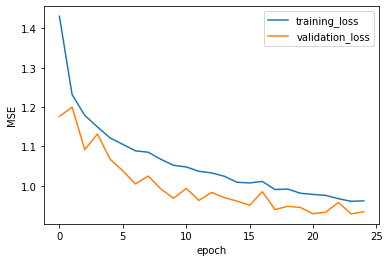

In [9]:
import matplotlib.pyplot as plt

# Visualize the training curve
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='training_loss')
plt.plot(history_df['val_loss'], label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
_ = plt.legend()

As shown in the training plot, the loss is gradually reduced with more iterations, which indicates the model is learning and making progress.

## 3. Generate predictions

Now our CNN model is trained, we can use it to predict on images in the evaluation set.

In [10]:
# Generate predictions on the evaluation set
predicted_ml = model.predict(eval_images)

# Compile predictions into the submission format
eval_labels.loc[:, 'pred_ml'] = predicted_ml
eval_submission = eval_labels.loc[:, ['SDSS_ID', 'pred_ml']]
eval_submission.head(3)

,SDSS_ID,pred_ml
0,1237657873256349729,2.998532
1,1237671260128411724,3.010330
2,1237658205036740751,3.027325


In [11]:
# Save the submission file
eval_submission.to_csv('./eval_submission.tsv', sep='\t', index=False)

Now you can submit this file for evaluation. 